Simulation model 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import xarray as xr

import pdb
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
from scipy.stats import norm, beta, bernoulli


import ml_estimation as ml
import model1_plots as mp

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

## parameters from fit

                 alpha                beta conv_b              alpha1  \
0  0.42954745334745603  1.2488387314065243   True  0.4750593142786862   

                beta1             alpha2              beta2  \
0  0.9959635793046289  3.035764318289129  86.60934028956832   

                    p conv_mb                  mu               sigma  
0  0.6904230509451326    True  0.6669502362883927  0.9276116143885261  
0.4750593142786862


array([5.31630499, 3.00777086, 2.30377508, 1.93211502, 1.69403826,
       1.52512852, 1.3974155 , 1.29654941, 1.21431603, 1.14563202,
       1.08716203, 1.0366155 , 0.99236072, 0.95319987, 0.91823128,
       0.88676162, 0.85824787, 0.83225794, 0.80844315, 0.78651868,
       0.76624927, 0.7474387 , 0.72992184, 0.71355863, 0.69822938,
       0.68383114, 0.67027484, 0.65748296, 0.64538772, 0.63392956,
       0.62305594, 0.61272033, 0.60288139, 0.59350228, 0.58455011,
       0.57599545, 0.56781194, 0.55997602, 0.55246664, 0.5452651 ,
       0.53835495, 0.531722  , 0.52535441, 0.51924305, 0.51338222,
       0.50777102, 0.5024164 , 0.49734011, 0.49259791, 0.48835031,
       0.48537232])

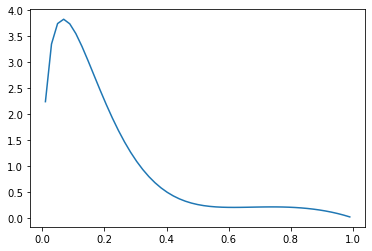

In [73]:
model1_cod = pd.read_csv('../mod/test/model1_cod.csv')
model1_cth = pd.read_csv('../mod/test/model1_cth.csv')
cstc = pd.read_csv('../mod/test/cstc_param.csv', index_col = 0).T
print(cstc)

cstc.loc[:, (cstc.columns != 'conv_b') & (cstc.columns != 'conv_mb' )] = cstc.loc[:, (cstc.columns != 'conv_b') & (cstc.columns != 'conv_mb' )].astype(float)
cstc

cod_param, cth_param = model1_cod.coef.values, model1_cth.coef.values
model1_cod, model1_cth
x = np.linspace(0.01,.99,51)
pdf = ml.pdf_bmix(x, 1.5, 8, 4, 2, .9)
plt.plot(x, pdf)
print(cstc.alpha1.iloc[0])
beta(cstc.alpha1.iloc[0], cstc.beta1.iloc[0]).pdf(x)

In [13]:
cstc.set_index([0])
cstc

KeyError: 'None of [0] are in the columns'

In [90]:
def modelThtoDistrTh(x, cod_param, cth_param):
    h, d = x
    Beta = cod_param[:4]
    gamma = cod_param[4:6]
    
    mu, sigma = ml.model1(h, d, Beta, gamma)

    gamma1 = cth_param[:4]
    a = cth_param[4:6]
    ab = cth_param[6:13]
    gamma2 = cth_param[13: 15]  
    
    mu1 = ml.mu1_est(h, d)
    mu1 = ml.redtoInt(mu1, 1e-4 , .9999)
    lognu1 = ml.nu1_est(h, d, gamma1 = gamma1)
    nu1 = np.exp(lognu1)
    p = ml.prob(h, d, a = a)
    mu2 = ml.mu2_est(h, d, ab = ab)
    mu2 = ml.redtoInt(mu2, 1e-4 , .9999)
    lognu2 = ml.nu2_est(h, d, gamma2 = gamma2)
    nu2 = np.exp(lognu2)
    return pd.Series({'mu' : mu, 'sigma' : sigma, 'mu1': mu1, 'nu1' : nu1, 'mu2' : mu2, 'nu2' : nu2, 'p' : p })
    
x = (3,4)
d = modelThtoDistrTh(x, model1_cod.coef.values, model1_cth.coef.values)

mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
n_h, n_d = len(mu_h), len(mu_d)

ds = xr.Dataset(
    data_vars=dict(
        # temperature=(["x", "y", "time"], temperature),
        # precipitation=(["x", "y", "time"], precipitation),
    ),
    coords=dict(
        # lon=(["x", "y"], lon),
        h=mu_h,
        d=mu_d,
    ),
#     attrs=dict(dh = dh, dd = dd),
    )

# ds.assign(mu = lambda x: modelThtoDistrTh((x.h, x.d), model1_cod.coef.values, model1_cth.coef.values))
# ds['mu'] = (['mu_h', 'mu_d'], mu.reshape(n_h, n_d))
h , d = np.meshgrid(mu_h, mu_d)
mu = np.zeros((n_h, n_d))
sigma = np.zeros((n_h, n_d))
mu1 = np.zeros((n_h, n_d))
nu1 = np.zeros((n_h, n_d))
p = np.zeros((n_h, n_d))
mu2 = np.zeros((n_h, n_d))
nu2 = np.zeros((n_h, n_d))

for (i, hi, di) in zip(range(n_d), h, d):
    for j, hij, dij in zip(range(n_h), hi, di):
        x = (hij, dij)
        param = modelThtoDistrTh(x, model1_cod.coef.values, model1_cth.coef.values)
        mu[j, i] = param.mu
        sigma[j, i] = param.sigma
        mu1[j, i] = param.mu1
        nu1[j, i] = param.nu1
        p[j, i] = param.p
        mu2[j, i] = param.mu2
        nu2[j, i] = param.nu2
#         print(i, j, hij, end = '\t')
        
len(hi), len(di), mu
ds['mu'] = (['h', 'd'], mu)
ds['sigma'] = (['h', 'd'], sigma)
ds['mu1'] = (['h', 'd'], mu1)
ds['nu1'] = (['h', 'd'], nu1)
ds['p'] = (['h', 'd'], p)
ds['mu2'] = (['h', 'd'], mu2)
ds['nu2'] = (['h', 'd'], nu2)


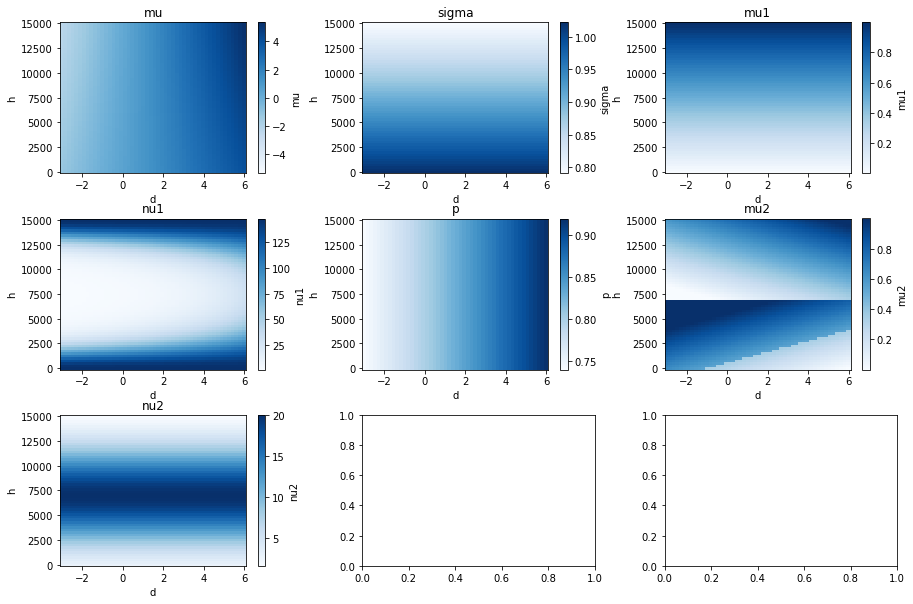

In [91]:
fig, ax = plt.subplots(3,3, figsize = (15, 10))
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
axs = ax.flatten()
for i, var in zip(range(7),list(ds.keys())):
    ds[var].plot(ax = axs[i], cmap = cm.Blues)
    axs[i].set(title = var)

## Simulation

In [92]:
def prob_to_cs(x, cs_param):
    if (x == np.nan).any(): # fixed prob
        return .7
    else:
        # insert function based on cs_param
        return .2

In [93]:
d = dict(x = 3)
d

{'x': 3}

In [94]:
def step(x, cod_param, cth_param, cs_param):
    """Makes one step.
    Args:
        x (np.array): current state of the pixel (h, d)
    Returns:
        np.array: updated state of the pixel
    """
#     print('x', x)
    p_cs = prob_to_cs(x, cs_param)

    # to cloud or clear sky
    cloud = bernoulli.rvs(p_cs)
    
    if cloud:
        
        if (x == np.nan).any(): ## x current is cloud
            pm = modelThtoDistrTh(x, cod_param, cth_param)
        #     print(pm)
            alpha1 = pm.mu1 * pm.nu1
            beta1 = pm.nu1 - alpha1
            alpha2 = pm.mu2 * pm.nu2
            beta2 = pm.nu2 - alpha2

        else: ## x is clear sky:
            pm = pd.Series(dict(p = .9 , 
                     mu = 1.5,
                     sigma = 1 ))
            alpha1 = 1.5
            beta1 = 8
            alpha2 = 4
            beta2 = 2
            
        d2 = np.random.randn(1) * pm.sigma + pm.mu   

        h_ = np.linspace(0, 1, 50)
        x = np.random.rand(1)
        y1 = beta.rvs(alpha1, beta1)
        y2 = beta.rvs(alpha2, beta2)
        u = (x < pm.p)
    #     print('u, y1, y2', u, y1 ,y2)
        h2 = ml.UnitInttoCTH(u * y1 + ~u * y2)
    
    else:
        h2, d2 = np.nan, np.nan
    
    return h2, d2

def sim_model1(steps, cod_param, cth_param, cs_param,
                       init_cond='random', impulse_pos='center'):
    """Generate the state of an elementary cellular automaton after a pre-determined
    number of steps starting from some random state.
    Args:
        rule_number (int): the number of the update rule to use
        size (int): number of cells in the row
        steps (int): number of steps to evolve the automaton
        init_cond (str): either `random` or `impulse`. If `random` every cell
        in the row is activated with prob. 0.5. If `impulse` only one cell
        is activated.
        impulse_pos (str): if `init_cond` is `impulse`, activate the
        left-most, central or right-most cell.
    Returns:
        np.array: final state of the automaton
    """

    x = np.zeros((steps, 2))
    x[0,:] = np.array([1e3, 1])
    for i in range(steps - 1):
#         print('\n step ',i)
        x[i+1,:] = step(x[i,:], cod_param, cth_param, cs_param)
    print('finished')
    return x

cs_param = 3
x = sim_model1(10000, model1_cod.coef.values, model1_cth.coef.values, cs_param)

finished


In [95]:
x.shape
x

array([[1000.,    1.],
       [  nan,   nan],
       [  nan,   nan],
       ...,
       [  nan,   nan],
       [  nan,   nan],
       [  nan,   nan]])

(<Figure size 1440x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015536F71310>,
       dtype=object))

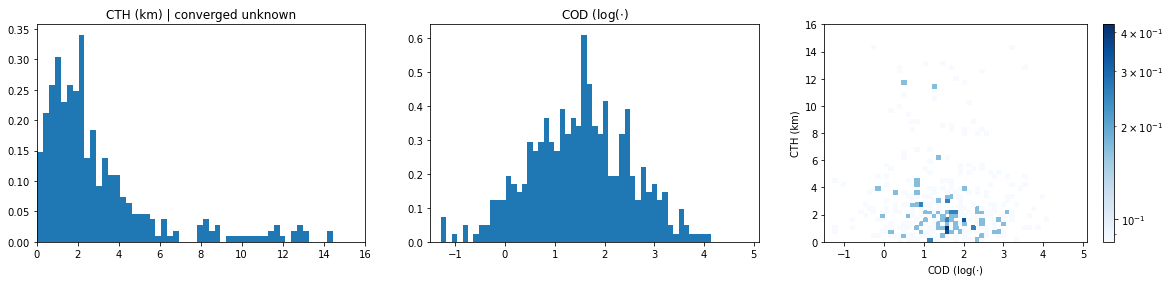

In [119]:
df = pd.DataFrame(x, columns = ['h_t', 'd_t'])
df = df.append({'h_t' : np.nan, 'd_t' : np.nan}, ignore_index = True)
df['h_t_next'] = np.roll(df.h_t, -1)
df['d_t_next'] = np.roll(df.d_t, -1)
df_cc = df.dropna()
mp.plot_distribution_next_cloud(df_cc, ML = False, density = True)

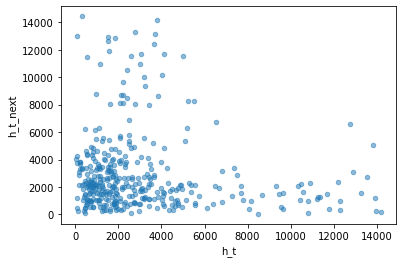

In [120]:
df.plot.scatter('h_t', 'h_t_next', alpha = .5)

C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
../lib\ml_estimation.py:66: RuntimeWarning: invalid value encountered in less_equal
  if p <= 0:
../lib\ml_estimation.py:68: RuntimeWarning: invalid value encountered in greater_equal
  elif p >= 1:
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarnin

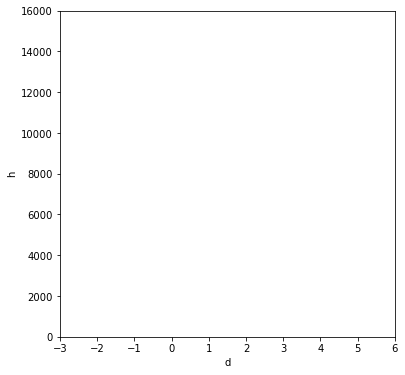

In [121]:
i = 19

fig = plt.figure(figsize =(6,6))
plt.xlim([-3, 6])
plt.ylim(np.array(mp.hlim) * 1e3)


def plot_state_with_distr(i, df = df):
    s = df.iloc[i]
    plt.title(f't = {i}')

    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)
    if i == 0: 
        cb = True
    else: 
        cb = False
    ds.pdf.plot.contour(add_colorbar = cb, levels = [.1, .5, 1, 2, 3, 6, 10])

    plt.scatter(s.d_t, s.h_t, label = '$s_t$')
    plt.scatter(s.d_t_next, s.h_t_next, label = '$s_{t+1}$')
    
    if cb:
        plt.legend()

plot_state_with_distr(i)
# x

In [122]:
def jointprob(s):
    plt.title(f't = {i}')

    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)
    return ds


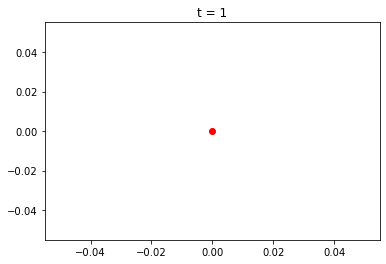

In [139]:
i = 1
s = df.iloc[i]
plt.title(f't = {i}')

cloudt = np.isnan(s.h_t)
# cloud
plt.scatter(0,0, c =  'r')

C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
../lib\ml_estimation.py:66: RuntimeWarning: invalid value encountered in less_equal
  if p <= 0:
../lib\ml_estimation.py:68: RuntimeWarning: invalid value encountered in greater_equal
  elif p >= 1:
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarnin

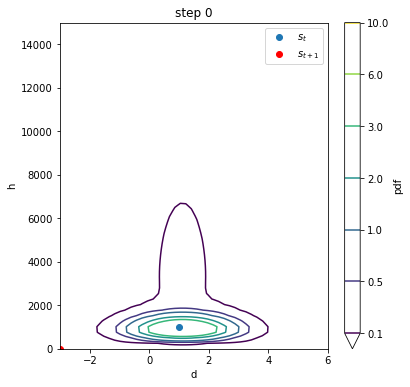

In [141]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
# fig = plt.figure()
# line, = ax.plot([], [], lw=2)

fig = plt.figure(figsize =(6,6))
ax = plt.axes()
plt.xlim([-3, 6])
plt.ylim(np.array(mp.hlim) * 1e3)
ds = jointprob(df.iloc[0])
ds.pdf.plot.contour( add_colorbar = True, levels = [.1, .5, 1, 2, 3, 6, 10], ax = ax)


# animation function.  This is called sequentially
def animate(i):
    ax.clear()
    s = df.iloc[i]
    plt.title(f't = {i}')

    cloudt = np.isnan(s.h_t)
    cloudt1 = np.isnan(s.h_t_next)
    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)

    ds.pdf.plot.contour(add_colorbar = False, levels = [.1, .5, 1, 2, 3, 6, 10], ax = ax)
    
    
    if cloudt:
        ax.scatter([-3], [0], c = 'r', label = '$s_t$')
    else: 
        ax.scatter(s.d_t, s.h_t, label = '$s_t$')
    
    if cloudt1:
        ax.scatter([-3], [0], c = 'r', label = '$s_{t+1}$')
    else:     
        ax.scatter(s.d_t_next, s.h_t_next, label = '$s_{t+1}$')
        
    ax.set_title('step ' + str(i))
    ax.legend()
    return 

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=100, interval=2000)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])



In [125]:
anim
